# Environemt Setup

In [1]:
!pip install openai==1.7.2 python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.1/212.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.2 MB/s eta 0:00:00


Import Modules and libraries

In [2]:
import json
import os, time
import pandas as pd
import matplotlib.pyplot as plt

from openai import OpenAI
# To load environment variables from .env files
from dotenv import load_dotenv

print("Modules are imported.")

Modules are imported.


Set-up the OpenAI API:


*   Prepare a .env file to store the OpenAI:
      1. API Key
      2. ORG ID
*   Upload the .env file to colab environment

*   Load the Key and ID





In [3]:
load_dotenv("apikey.env.txt")

# Get the environment variables
APIKEY = os.getenv("APIKEY")
ORGID = os.getenv("ORGID")

In [4]:
# Create the Client

client = OpenAI(
    api_key = APIKEY,
    organization = ORGID
)

client

# Preparing the training data

Upload the Costomer_Complaint.csv file to the colab environment

In [5]:
training_data = pd.read_csv('Customer Complaints.csv')
training_data

,Complaints,Details
0,Unreliable internet! Sick of constant outages...,"{""Topic"": ""Internet"", ""Problem"": ""Unreliable s..."
1,TV signal keeps dropping during crucial momen...,"{""Topic"": ""TV"", ""Problem"": ""Signal dropout"", ""..."
2,Phone line always crackling! Can't hear a thi...,"{""Topic"": ""Phone"", ""Problem"": ""Crackling line""..."
3,Ridiculous prices for such terrible service! ...,"{""Topic"": ""Billing"", ""Problem"": ""Overcharged"",..."
4,Internet speed slower than a snail! Can't str...,"{""Topic"": ""Internet"", ""Problem"": ""Slow speed"",..."
...,...,...
62,Poor call quality during international calls! ...,"{""Topic"": ""Phone"", ""Problem"": ""Poor call quali..."
63,Incorrect charges on my bill every month! Unre...,"{""Topic"": ""Billing"", ""Problem"": ""Incorrect cha..."
64,This service is terrible! Can't believe I'm pa...,"{""Topic"": ""PulseNet General"", ""Problem"": ""Gene..."
65,This product is a complete waste of money! Dis...,"{""Topic"": ""PulseNet General"", ""Problem"": ""Gene..."


Prepare the training data for the fine-tuning process. Each data row needs to be converted into a JSON object which is supported by OpenAI format.

The data will be in the following format:

<pre>
<code>
{
  <span style="color: blue;">"messages"</span>: [
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"system"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">Here we provide the context about the user's prompt.
                  (info about instructions or details regarding the conversation)</span>"
    },
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"user"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">The user's prompt i.e. going to be user's complaint</span>"
    },
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"assistant"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">Details extracted by the assistant from the corresponding complaint
                  by the user.</span>"
    }
  ]
}
</code>
</pre>

In [6]:
def save_as_json(row):

  system_content = """
      Extract and return the following complaint in json (dict) format:
      - Topic: The product/department that the customer has a complaint about.
      - Problem: A two to three-word description of what exactly the problem is.
      - Customer_Dissatisfaction_Index: number between 0 and 100 indicating
                                        anger from customer about the problem.
  """

  formatted_data = {
        "messages": [
            {"role": "system", "content": system_content},
            {"role": "user", "content": row.Complaints},
            {"role": "assistant", "content": row.Details}
        ]
      }

  # Append every row to the json file
  with open("training_data.json", "a") as json_file:
        json.dump(formatted_data, json_file)
        json_file.write("\n")

Pass the data to the method to convert dataframe into json format.

In [7]:
# Iterate through every row one by one and pass it to the function "save_as_json"
for index, row in training_data.iterrows():
  save_as_json(row)

# Fine-tune the model GPT 3.5

In [8]:
# Import the json file for the training data for fine tuning

data_file = client.files.create(
    file = open('training_data.json', 'rb'),
    purpose = 'fine-tune',
)

data_file

FileObject(id='file-lqWcHxgi8Xav4yDCbKsdb55J', bytes=45650, created_at=1722769383, filename='training_data.json', object='file', purpose='fine-tune', status='processed', status_details=None)

Creating a fine-tuning job

In [9]:
# Training file object is ready, we can start with fine tuning the LLM

fine_tuning_job = client.fine_tuning.jobs.create(
    training_file = data_file.id,    # Our training file
    model = 'gpt-3.5-turbo',         # Model we want to fine tune
    hyperparameters = {
        "n_epochs" : 'auto'
    }
)

fine_tuning_job

FineTuningJob(id='ftjob-yXdfDiVYEK9n0pQKGoogXdWx', created_at=1722769392, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-AlEzKDQJ2igZgsjjUpU2cEi2', result_files=[], status='validating_files', trained_tokens=None, training_file='file-lqWcHxgi8Xav4yDCbKsdb55J', validation_file=None, user_provided_suffix=None, seed=1235186436, estimated_finish=None, integrations=[])

Retrieving the status of the fine-tuning job to ensure the task is finished.

In [10]:
while True:

  time.sleep(2)

  # This method when getting the fine tuning job id returns the object again
  # So we can use this retrieved object to check the status of the job
  retrieved_job = client.fine_tuning.jobs.retrieve(fine_tuning_job.id)
  status = retrieved_job.status
  print(status)

  if(status == 'succeeded'):
    print("Fine Tuning Job Succeeeded")
    break

validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
validating_files
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running


# Model Evaluation

Observe the learning process of our fine-tuning job by retrieving the event messages.

*   Events
*   Messages
*   Metrics





In [11]:
# list_events method takes the id of the fine tuning job  and return the learning preocess in the form of points mentioned above.

client.fine_tuning.jobs.list_events(fine_tuning_job_id = retrieved_job.id, limit = 100).data

[FineTuningJobEvent(id='ftevent-LF85wabG41H7OTXW7g68ifz3', created_at=1722769892, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-KLS9Z6T5oeOujnCOQq9BoC2n', created_at=1722769889, level='info', message='New fine-tuned model created: ft:gpt-3.5-turbo-0125:personal::9sTR2OdS', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-vdiQ1TsZdZGLGuBO20FoxNuD', created_at=1722769889, level='info', message='Checkpoint created at step 134 with Snapshot ID: ft:gpt-3.5-turbo-0125:personal::9sTR2GEy:ckpt-step-134', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-0MmBKOYmTYi2QxZX29g7VpTA', created_at=1722769889, level='info', message='Checkpoint created at step 67 with Snapshot ID: ft:gpt-3.5-turbo-0125:personal::9sTR2Agx:ckpt-step-67', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftev

In [12]:
events = list(client.fine_tuning.jobs.list_events(fine_tuning_job_id = retrieved_job.id, limit = 100).data)

for event in events:
  print(event.message)

The job has successfully completed
New fine-tuned model created: ft:gpt-3.5-turbo-0125:personal::9sTR2OdS
Checkpoint created at step 134 with Snapshot ID: ft:gpt-3.5-turbo-0125:personal::9sTR2GEy:ckpt-step-134
Checkpoint created at step 67 with Snapshot ID: ft:gpt-3.5-turbo-0125:personal::9sTR2Agx:ckpt-step-67
Step 201/201: training loss=0.04
Step 200/201: training loss=0.14
Step 199/201: training loss=0.02
Step 198/201: training loss=0.13
Step 197/201: training loss=0.04
Step 196/201: training loss=0.04
Step 195/201: training loss=0.07
Step 194/201: training loss=0.02
Step 193/201: training loss=0.03
Step 192/201: training loss=0.05
Step 191/201: training loss=0.00
Step 190/201: training loss=0.05
Step 189/201: training loss=0.11
Step 188/201: training loss=0.03
Step 187/201: training loss=0.03
Step 186/201: training loss=0.02
Step 185/201: training loss=0.02
Step 184/201: training loss=0.00
Step 183/201: training loss=0.08
Step 182/201: training loss=0.00
Step 181/201: training loss=

In [13]:
# In every event the progress is stored in the following way
for event in events:
  print(event.data)

{}
{}
{}
{}
{'step': 201, 'train_loss': 0.0383928082883358, 'total_steps': 201, 'train_mean_token_accuracy': 0.9629629850387573}
{'step': 200, 'train_loss': 0.13929465413093567, 'total_steps': 201, 'train_mean_token_accuracy': 0.9259259104728699}
{'step': 199, 'train_loss': 0.021748732775449753, 'total_steps': 201, 'train_mean_token_accuracy': 1.0}
{'step': 198, 'train_loss': 0.12803928554058075, 'total_steps': 201, 'train_mean_token_accuracy': 0.9230769276618958}
{'step': 197, 'train_loss': 0.041477661579847336, 'total_steps': 201, 'train_mean_token_accuracy': 0.9599999785423279}
{'step': 196, 'train_loss': 0.04347191005945206, 'total_steps': 201, 'train_mean_token_accuracy': 0.9599999785423279}
{'step': 195, 'train_loss': 0.07302263379096985, 'total_steps': 201, 'train_mean_token_accuracy': 0.9629629850387573}
{'step': 194, 'train_loss': 0.020565491169691086, 'total_steps': 201, 'train_mean_token_accuracy': 1.0}
{'step': 193, 'train_loss': 0.029163291677832603, 'total_steps': 201, 't

Store the 'step' and 'train_loss' in a list

In [14]:
steps = []
train_loss = []

for event in events:
  if event.data:
    steps.append(event.data['step'])
    train_loss.append(event.data['train_loss'])

print(steps)
print(train_loss)

[201, 200, 199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106]
[0.0383928082883358, 0.13929465413093567, 0.021748732775449753, 0.12803928554058075, 0.041477661579847336, 0.04347191005945206, 0.07302263379096985, 0.020565491169691086, 0.029163291677832603, 0.04581430181860924, 5.1569054448918905e-06, 0.047587890177965164, 0.11155451089143753, 0.030781541019678116, 0.028768004849553108, 0.023938242346048355, 0.016489101573824883, 6.075258625060087e-06, 0.07979018986225128, 0.00018169262330047786, 0.10148490965366364, 0.2248864322900772, 0.4085005223751068, 0.06401266902685165, 

Visualize a line chart for training loss for every step

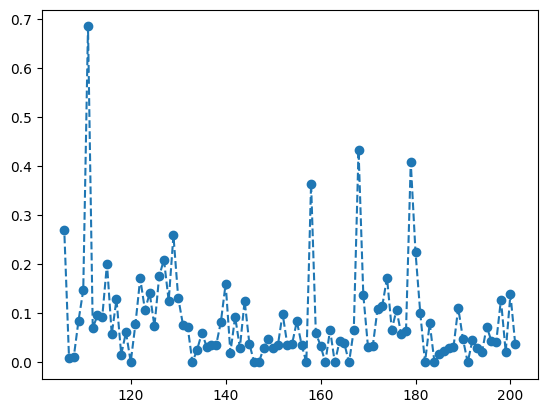

In [15]:
plt.plot(steps, train_loss, marker = 'o', linestyle = '--')

# Deploying the model

In [16]:
llm_updated = retrieved_job.fine_tuned_model
print(llm_updated)

ft:gpt-3.5-turbo-0125:personal::9sTR2OdS


Extract the information from a user complaint by using our new updated LLM by defining a method which will return the results

In [17]:
def extract_details(user_complaint, model_name):
    """
    Function will return data in JSON (dict) format by extracting information from a user complaint using our updated specific LLM:

    Parameters:
    user_complaint (str): User's complaint.
    model_name (str): Name of the specific LLM model used for info extraction.
    """

    system_content = """
        Return the following information in JSON (dict) format:
        - Topic
        - Problem
        - Customer_Dissatisfaction_Index
    """

    # Generate a response using the specified model and the user's complaint
    response = client.chat.completions.create(
        model = model_name,
        messages=[
            {"role": "system", "content": system_content},  # System content explaining the expected output
            {"role": "user", "content": user_complaint}  # User's complaint passed as content
        ]
    )

    # Return the response generated by the updated specific LLM model
    return response.choices[0].message.content

Let us now use the updated fine tuned LLM to observe the results

In [18]:
complaint = "Extra fees added to my bill! What's going on? Extremely annoyed with this service!"
extract_details(complaint, llm_updated)

'{"Topic": "Billing", "Problem": "Extra fees added to bill", "Customer_Dissatisfaction_Index": 10}'

Assess the GPT-4 model for the same complaint

In [19]:
extract_details(complaint, 'gpt-4')

'{\n  "Topic": "Billing",\n  "Problem": "Unexpected extra fees added to bill",\n  "Customer_Dissatisfaction_Index": 8\n}'

Let's try a different complaint

In [20]:
complaint = "Service and recption is completely terrible! Total waste of money!"
extract_details(complaint, llm_updated)

'{"Topic": "Customer Service", "Problem": "Terrible service and reception", "Customer_Dissatisfaction_Index": 90}'

Assess the GPT-4 model for the same complaint

In [21]:
extract_details(complaint, 'gpt-4')

'{\n    "Topic": "Service and Reception",\n    "Problem": "Completely terrible service and reception, perceived as a waste of money",\n    "Customer_Dissatisfaction_Index": 10\n}'

Another complaint:

In [22]:
complaint = "Parts of packages missing! Misleading marketing! Outraged!!"
extract_details(complaint, llm_updated)

'{"Topic": "Misleading marketing", "Problem": "Parts of packages missing", "Customer_Dissatisfaction_Index": 10}'

Assess the GPT-4 model for the above complaint

In [23]:
extract_details(complaint, 'gpt-4')

'{\n  "Topic": "Package Delivery",\n  "Problem": "Parts of packages missing and misleading marketing",\n  "Customer_Dissatisfaction_Index": "High"\n}'

## Conclusion : Since our model is fine-tuned to the dataset, we can notice the difference in the results and can conclude that our fine-tuned model is generating better output.